In [16]:
"""
Debug / visualization script for signal ICL pipeline.

It tests:
  - Data sampler (SignalSampler)
  - Task (SignalConvolutionTask)
  - Curriculum schedule

and shows the results via matplotlib plots.

Usage:
  python debug_signal_icl.py
"""

import math
from types import SimpleNamespace

import torch
import matplotlib.pyplot as plt

from samplers import get_data_sampler      # your sampler.py
from tasks import get_task_sampler        # your tasks.py
from curriculum import Curriculum         # your curriculum.py

def interleaved_to_complex(vec_2p: torch.Tensor) -> torch.Tensor:
    """
    vec_2p: (..., 2p) real, [Re0, Im0, Re1, Im1, ...]
    returns: (..., p) complex
    """
    re = vec_2p[..., 0::2]
    im = vec_2p[..., 1::2]
    return torch.complex(re, im)


def to_time_domain(x: torch.Tensor, p: int, fft_norm: str = "ortho") -> torch.Tensor:
    """
    Convert x to time domain if needed.

    - If last dim == p: assume already time domain, return as-is
    - If last dim == 2p: assume interleaved freq domain, apply IFFT
    """
    D = x.shape[-1]
    if D == p:
        return x
    elif D == 2 * p:
        z = interleaved_to_complex(x)
        return torch.fft.ifft(z, dim=-1, norm=fft_norm).real
    else:
        raise ValueError(f"Unexpected last dim {D}, expected {p} or {2*p}")


# ============================================================
# Config for tests (edit these to match your experiment)
# ============================================================

P = 20                  # signal period / time-domain length
DOMAIN = "time"         # "time" or "freq"
BATCH_SIZE = 4
N_POINTS_TEST = 5       # number of (x,y) pairs to visualize

FIR_LEN = 10
FIR_DIST = "normal"     # "normal" or "uniform"
AMP_DIST = "normal"
AMP_STD = 1.0
NUM_FREQS = 20          # harmonics for sampler

DEVICE = "cpu"          # for this debug script, keep it simple


# ============================================================
# 1. Test the data sampler
# ============================================================

def test_sampler():
    print("=== Testing data sampler ===")
    n_dims = P if DOMAIN == "time" else 2 * P

    data_sampler = get_data_sampler(
        "signal",
        n_dims=n_dims,
        p=P,
        domain=DOMAIN,
        amp_dist=AMP_DIST,
        amp_std=AMP_STD,
        num_freqs=NUM_FREQS,
        device=DEVICE,
    )

    xs = data_sampler.sample_xs(
        n_points=N_POINTS_TEST,
        b_size=BATCH_SIZE,
        n_dims_truncated=None,
        seeds=None,           # or list of seeds for deterministic rows
    )  # shape: (B, N_POINTS_TEST, n_dims)

    print("xs shape:", xs.shape)

    # Plot first batch row, all points, in time domain
    xs_time = to_time_domain(xs, P)      # (B, N_POINTS_TEST, P)
    t = torch.arange(P).numpy()

    fig, axes = plt.subplots(N_POINTS_TEST, 1, figsize=(8, 2.0 * N_POINTS_TEST), sharex=True)
    fig.suptitle("Sampler outputs (batch row 0)")

    if N_POINTS_TEST == 1:
        axes = [axes]

    for i in range(N_POINTS_TEST):
        axes[i].stem(
            t,
            xs_time[0, i].numpy(),        )
        axes[i].set_ylabel(f"x[{i}]")
    axes[-1].set_xlabel("time index")

    plt.tight_layout()
    plt.show()


# ============================================================
# 2. Test the task (SignalConvolutionTask)
# ============================================================

def test_task():
    print("=== Testing task (SignalConvolutionTask) ===")
    n_dims = P if DOMAIN == "time" else 2 * P

    # Rebuild sampler and task
    data_sampler = get_data_sampler(
        "signal",
        n_dims=n_dims,
        p=P,
        domain=DOMAIN,
        amp_dist=AMP_DIST,
        amp_std=AMP_STD,
        num_freqs=NUM_FREQS,
        device=DEVICE,
    )

    task_sampler = get_task_sampler(
        "signal_conv",
        n_dims,
        BATCH_SIZE,
        p=P,
        fir_len=FIR_LEN,
        domain=DOMAIN,
        fir_dist=FIR_DIST,
        normalize_fir=True,
        device=DEVICE,
    )

    xs = data_sampler.sample_xs(
        n_points=N_POINTS_TEST,
        b_size=BATCH_SIZE,
        n_dims_truncated=None,
        seeds=None,
    )
    task = task_sampler()
    ys = task.evaluate(xs)

    print("xs shape:", xs.shape)
    print("ys shape:", ys.shape)

    xs_time = to_time_domain(xs, P)   # (B, N_POINTS_TEST, P)
    ys_time = to_time_domain(ys, P)   # (B, N_POINTS_TEST, P)
    t = torch.arange(P).numpy()

    # Plot x and y for a single (batch row, point)
    row = 0
    point = 0

    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.stem(
        t,
        xs_time[row, point].numpy(),
        label="x (input)",
    )
    ax.stem(
        t,
        ys_time[row, point].numpy(),
        linefmt="r-",
        markerfmt="ro",
        basefmt="k-",
        label="y = h * x (output)",
    )
    ax.set_title(f"Task convolution example (row={row}, point={point})")
    ax.set_xlabel("time index")
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Optional: show multiple points for same row
    fig, axes = plt.subplots(2, N_POINTS_TEST, figsize=(4 * N_POINTS_TEST, 6), sharex=True, sharey=True)
    fig.suptitle("x vs y for all points (row 0)")

    for i in range(N_POINTS_TEST):
        axes[0, i].stem(
            t,
            xs_time[row, i].numpy(),
        )
        axes[0, i].set_title(f"x[{i}]")
        axes[1, i].stem(
            t,
            ys_time[row, i].numpy(),
        )
        axes[1, i].set_title(f"y[{i}]")

    for ax in axes[-1, :]:
        ax.set_xlabel("time index")

    plt.tight_layout()
    plt.show()


# ============================================================
# 3. Test curriculum
# ============================================================

def test_curriculum():
    print("=== Testing curriculum ===")

    # Fake args object that matches what Curriculum expects:
    curriculum_cfg = SimpleNamespace(
        dims=SimpleNamespace(start=20, end=20, inc=0, interval=1),
        points=SimpleNamespace(start=5, end=41, inc=1, interval=2000),
    )

    curr = Curriculum(curriculum_cfg)

    total_steps = 10000
    steps = []
    n_points_list = []
    n_dims_list = []

    for step in range(total_steps):
        steps.append(step)
        n_points_list.append(curr.n_points)
        n_dims_list.append(curr.n_dims_truncated)
        curr.update()

    import numpy as np
    steps = np.array(steps)
    n_points_list = np.array(n_points_list)
    n_dims_list = np.array(n_dims_list)

    fig, ax1 = plt.subplots(figsize=(8, 4))
    ax1.plot(steps, n_points_list, label="n_points")
    ax1.set_xlabel("training step")
    ax1.set_ylabel("n_points")
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(steps, n_dims_list, color="tab:red", label="n_dims_truncated")
    ax2.set_ylabel("n_dims_truncated")

    fig.suptitle("Curriculum schedule")
    plt.tight_layout()
    plt.show()

=== Testing data sampler ===
xs shape: torch.Size([4, 5, 20])


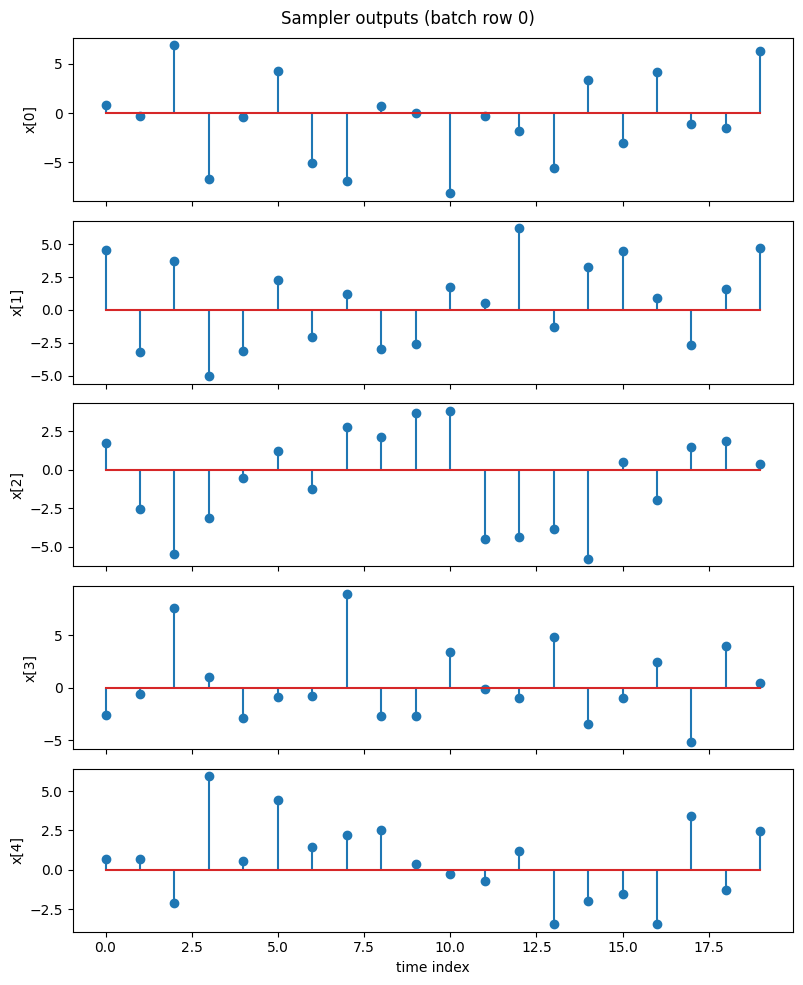

In [17]:
torch.manual_seed(0)

# 1) Inspect sampler outputs
test_sampler()


=== Testing task (SignalConvolutionTask) ===
xs shape: torch.Size([4, 5, 20])
ys shape: torch.Size([4, 5, 20])


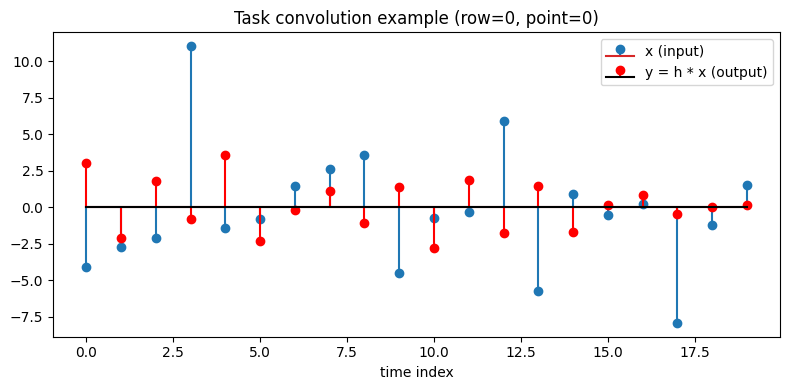

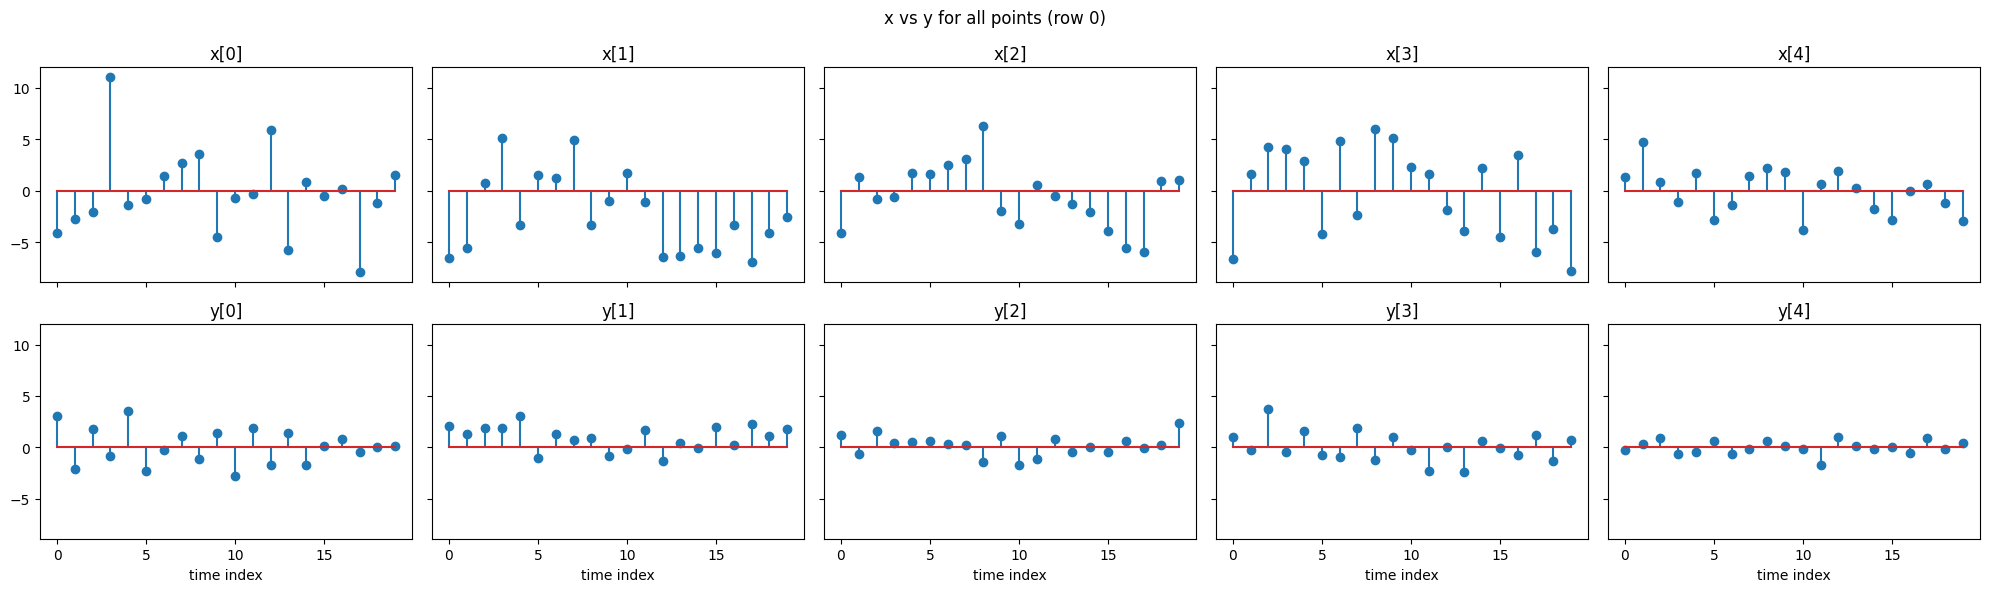

In [18]:
test_task()

=== Testing curriculum ===


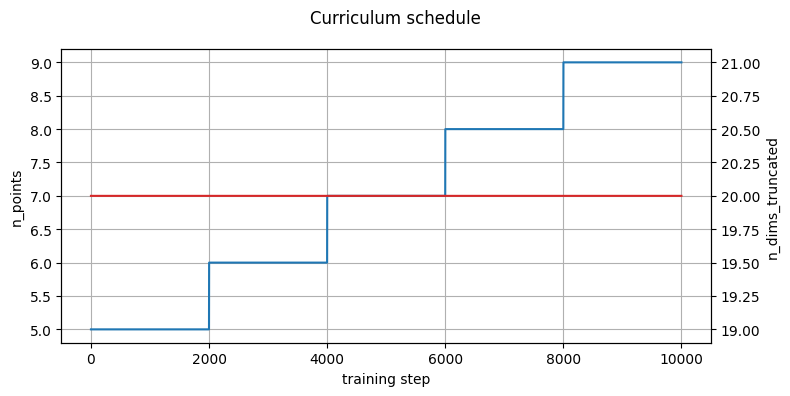

In [19]:
test_curriculum()






